<a href="https://colab.research.google.com/github/n4k5h47r4/Predicting-Redshift/blob/main/Predicting_redshift_w_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#@title PREPROCESSING (ASTRODASH)
class ProcessingTools(object):
    def redshift_spectrum(self, wave, flux, z):
        wave_new = wave * (z + 1)

        return wave_new, flux

    def deredshift_spectrum(self, wave, flux, z):
        wave_new = wave / (z + 1)

        return wave_new, flux

    def min_max_index(self, flux, outerVal=0):
        """
        :param flux:
        :param outerVal: is the scalar value in all entries before the minimum and after the maximum index
        :return:
        """
        nonZeros = np.where(flux != outerVal)[0]
        if nonZeros.size:
            minIndex, maxIndex = min(nonZeros), max(nonZeros)
        else:
            minIndex, maxIndex = len(flux), len(flux)

        return minIndex, maxIndex


class PreProcessSpectrum(object):
    def __init__(self, w0, w1, nw):
        self.w0 = w0
        self.w1 = w1
        self.nw = nw
        self.dwlog = np.log(w1 / w0) / nw
        self.processingTools = ProcessingTools()

    def log_wavelength(self, wave, flux):
        # Set up log wavelength array bins
        wlog = self.w0 * np.exp(np.arange(0, self.nw) * self.dwlog)

        fluxOut = self._vectorised_log_binning(wave, flux)
        # fluxOut = self._original_log_binning(wave, flux)

        minIndex, maxIndex = self.processingTools.min_max_index(fluxOut, outerVal=0)

        return wlog, fluxOut, minIndex, maxIndex

    def _vectorised_log_binning(self, wave, flux):
        """ Vectorised code version of the self._original_log_binning (for improved speed since this is the most called
        function in the script during training). This is complicated, but it has been tested to match the slower
        looping method """

        spec = np.array([wave, flux]).T
        mask = (wave >= self.w0) & (wave < self.w1)
        spec = spec[mask]
        wave, flux = spec.T
        try:
            fluxOut = np.zeros(int(self.nw))
            waveMiddle = wave[1:-1]
            waveTake1Index = wave[:-2]
            wavePlus1Index = wave[2:]
            s0List = 0.5 * (waveTake1Index + waveMiddle)
            s1List = 0.5 * (waveMiddle + wavePlus1Index)
            s0First = 0.5 * (3 * wave[0] - wave[1])
            s0Last = 0.5 * (wave[-2] + wave[-1])
            s1First = 0.5 * (wave[0] + wave[1])
            s1Last = 0.5 * (3 * wave[-1] - wave[-2])
            s0List = np.concatenate([[s0First], s0List, [s0Last]])
            s1List = np.concatenate([[s1First], s1List, [s1Last]])
            s0LogList = np.log(s0List / self.w0) / self.dwlog + 1
            s1LogList = np.log(s1List / self.w0) / self.dwlog + 1
            dnuList = s1List - s0List

            s0LogListInt = s0LogList.astype(int)
            s1LogListInt = s1LogList.astype(int)
            numOfJLoops = s1LogListInt - s0LogListInt
            jIndexes = np.flatnonzero(numOfJLoops)
            jIndexVals = s0LogListInt[jIndexes]
            prependZero = jIndexVals[0] if jIndexVals[0] < 0 else False
            if prependZero is not False:
                jIndexVals[0] = 0
                numOfJLoops[0] += prependZero
            numOfJLoops = (numOfJLoops[jIndexes])[jIndexVals < self.nw]
            fluxValList = ((flux * 1 / (s1LogList - s0LogList) * dnuList)[jIndexes])[jIndexVals < self.nw]
            fluxValList = np.repeat(fluxValList, numOfJLoops)
            minJ = min(jIndexVals)
            maxJ = (max(jIndexVals) + numOfJLoops[-1]) if (max(jIndexVals) + numOfJLoops[-1] < self.nw) else self.nw
            fluxOut[minJ:maxJ] = fluxValList[:(maxJ - minJ)]

            return fluxOut
        except Exception as e:
            print(e)
            print('wave', wave)
            print('flux', flux)
            print("########################################ERROR#######################################\n\n\n\n")
            return np.zeros(self.nw)

    def _original_log_binning(self, wave, flux):
        """ Rebin wavelengths: adapted from SNID apodize.f subroutine rebin() """
        fluxOut = np.zeros(int(self.nw))

        for i in range(0, len(wave)):
            if i == 0:
                s0 = 0.5 * (3 * wave[i] - wave[i + 1])
                s1 = 0.5 * (wave[i] + wave[i + 1])
            elif i == len(wave) - 1:
                s0 = 0.5 * (wave[i - 1] + wave[i])
                s1 = 0.5 * (3 * wave[i] - wave[i - 1])
            else:
                s0 = 0.5 * (wave[i - 1] + wave[i])
                s1 = 0.5 * (wave[i] + wave[i + 1])

            s0log = np.log(s0 / self.w0) / self.dwlog + 1
            s1log = np.log(s1 / self.w0) / self.dwlog + 1
            dnu = s1 - s0

            for j in range(int(s0log), int(s1log)):
                if j < 0 or j >= self.nw:
                    continue
                alen = 1  # min(s1log, j+1) - max(s0log, j)
                fluxval = flux[i] * alen / (s1log - s0log) * dnu
                fluxOut[j] = fluxOut[j] + fluxval

        return fluxOut

    def spline_fit(self, wave, flux, numSplinePoints, minindex, maxindex):
        continuum = np.zeros(int(self.nw)) + 1
        if (maxindex - minindex) > 5:
            spline = UnivariateSpline(wave[minindex:maxindex + 1], flux[minindex:maxindex + 1], k=3)
            splineWave = np.linspace(wave[minindex], wave[maxindex], num=numSplinePoints, endpoint=True)
            splinePoints = spline(splineWave)

            splineMore = UnivariateSpline(splineWave, splinePoints, k=3)
            splinePointsMore = splineMore(wave[minindex:maxindex + 1])

            continuum[minindex:maxindex + 1] = splinePointsMore
        else:
            print("WARNING: LESS THAN 6 POINTS IN SPECTRUM")

        return continuum

    def continuum_removal(self, wave, flux, numSplinePoints, minIndex, maxIndex):
        flux = flux + 1  # Important to keep this as +1
        contRemovedFlux = np.copy(flux)

        splineFit = self.spline_fit(wave, flux, numSplinePoints, minIndex, maxIndex)
        contRemovedFlux[minIndex:maxIndex + 1] = flux[minIndex:maxIndex + 1] / splineFit[minIndex:maxIndex + 1]
        contRemovedFluxNorm = normalise_spectrum(contRemovedFlux - 1)
        contRemovedFluxNorm = zero_non_overlap_part(contRemovedFluxNorm, minIndex, maxIndex)

        return contRemovedFluxNorm, splineFit - 1

    def mean_zero(self, flux, minindex, maxindex):
        """mean zero flux"""
        meanflux = np.mean(flux[minindex:maxindex])
        meanzeroflux = flux - meanflux
        meanzeroflux[0:minindex] = flux[0:minindex]
        meanzeroflux[maxindex + 1:] = flux[maxindex + 1:]

        return meanzeroflux

    def apodize(self, flux, minindex, maxindex, outerVal=0):
        """apodize with 5% cosine bell"""
        percent = 0.05
        fluxout = np.copy(flux) - outerVal

        nsquash = int(self.nw * percent)
        for i in range(0, nsquash):
            arg = np.pi * i / (nsquash - 1)
            factor = 0.5 * (1 - np.cos(arg))
            if (minindex + i < self.nw) and (maxindex - i >= 0):
                fluxout[minindex + i] = factor * fluxout[minindex + i]
                fluxout[maxindex - i] = factor * fluxout[maxindex - i]
            else:
                print("INVALID FLUX IN PREPROCESSING.PY APODIZE()")
                print("MININDEX=%d, i=%d" % (minindex, i))
                break

        if outerVal != 0:
            fluxout = fluxout + outerVal
            fluxout = zero_non_overlap_part(fluxout, minindex, maxindex, outerVal=outerVal)

        return fluxout

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
%cd /content/gdrive/My Drive/sne

/content/gdrive/My Drive/sne


In [ ]:
# Get filenames
filepaths = []
for subdir, dirs, files in os.walk('.'):
    for file in files:
        filepaths.append(os.path.join(subdir, file))
print(filepaths)

['./Ia/sn1989b.p18.dat', './Ia/sn1989b.p08.dat', './Ia/sn1989b.p17.dat', './Ia/sn1998aq.p19.dat', './Ia/sn1996x.p57.dat', './Ia/sn1989b.p09.dat', './Ia/sn1999aa.m11.dat', './Ia/sn1991bg.p52.dat', './Ia/sn1991bg.p23.dat', './Ia/sn1989b.p03.dat', './Ia/sn2001ay.p09.dat', './Ia/sn1981b.p20.dat', './Ia/sn1994d.p20.dat', './Ia/sn1999ac.p39.dat', './Ia/sn1990n.p38.dat', './Ia/sn1989b.p19.dat', './Ia/sn2001ay.p21.dat', './Ia/sn2002bo.m01.dat', './Ia/sn1999ac.m15.dat', './Ia/sn1999ac.p11.dat', './Ia/sn2001ay.p26.dat', './Ia/sn1989b.p16.dat', './Ia/sn1999ac.m11.dat', './Ia/sn1999ac.p08.dat', './Ia/sn1994d.m05.dat', './Ia/sn1991bg.max.dat', './Ia/sn1996x.m01.dat', './Ia/sn1991t.p45.dat', './Ia/sn1999ac.p42.dat', './Ia/sn1999ac.m09.dat', './Ia/sn2002bo.m11.dat', './Ia/sn1986g.p41.dat', './Ia/sn1998aq.p01.dat', './Ia/sn1986g.p44.dat', './Ia/sn1999ee.p03.dat', './Ia/sn1989b.p05.dat', './Ia/sn1994d.p18.dat', './Ia/sn1994d.m04.dat', './Ia/sn1989b.m01.dat', './Ia/sn1986g.p22.dat', './Ia/sn1998bu.p27.d

./Ia/sn1989b.p18.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998aq.p19.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1996x.p57.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p52.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p23.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2001ay.p09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p20.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p20.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.p38.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p19.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2001ay.p21.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2002bo.m01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2001ay.p26.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p16.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.m05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1996x.m01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.p45.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2002bo.m11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.p41.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998aq.p01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.p44.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p18.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.m04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.m01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.p22.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998bu.p27.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998aq.m09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.p67.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.m05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.m08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.m02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998bu.p10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2001ay.p16.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998bu.m02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.p10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p26.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p28.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998aq.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p16.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.p89.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p35.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.m03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2003du.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2002bo.m14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.m14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.m03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p37.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2001ay.p01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p30.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p25.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2002bo.m13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1996x.p32.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2002bo.m05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p58.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p49.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p06.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1996x.p23.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.m09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.p17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.p24.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.m08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.m04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p105.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p44.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p76.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1996x.p02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.m05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1986g.p102.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1989b.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.m10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p16.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998aq.m08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2001ay.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2003du.m11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2003du.p13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991t.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1998bu.m04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1981b.p64.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1994d.p02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn2010zz.p100.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.m01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1991bg.p16.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p46.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.p24.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1992a.m05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ia/sn1990n.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2002ao.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1983V.p18.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1999di.p45.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1984L.p73.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2002ao.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1987M.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1984L.p34.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.m17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005e.p06.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p21.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005e.p26.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1998dt.p33.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005la.u23.dat
./Ib/sn2006jc.p35.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2000er.u03.dat
./Ib/sn2008d.p40.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p18.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1983V.m09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p36.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p33.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2000er.u06.dat
./Ib/sn1991ar.u16.dat
./Ib/sn1999dn.p38.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p62.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1990u.p70.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1983N.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1999ex.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1999dn.p10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p37.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p29.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.m13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1990u.p12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1983V.p38.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2000er.u07.dat
./Ib/sn1984L.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1999ex.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p39.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p25.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005la.u10.dat
./Ib/sn2000h.p30.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p54.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.m10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1984L.p30.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1999dn.p17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.m14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p34.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005e.p59.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1996cb.u63.dat
./Ib/sn1999di.p21.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.m12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1997dd.u00.dat
./Ib/sn2008d.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p84.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1998dt.p08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.p30.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2006jc.p67.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1999ex.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2008d.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005la.u11.dat
./Ib/sn1984L.p10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2000er.u04.dat
./Ib/sn2000er.u02.dat
./Ib/sn1983N.p12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2002ao.p12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1983V.p12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn1990u.p41.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ib/sn2005la.u05.dat
./Ib/sn1984L.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1997ef.p108.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn2002ap.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.p13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1994I.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1991a.u11.dat
./Ic/sn1991n.u251.dat
./Ic/sn1998bw.p19.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1994I.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1991n.u28.dat
./Ic/sn1990b.p39.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1997ef.p51.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1991a.u48.dat
./Ic/sn1991a.u00.dat
./Ic/sn1991k.u14.dat
./Ic/sn1991a.u17.dat
./Ic/sn1997ef.p89.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1997c.u00.dat
./Ic/sn2002ap.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1999bv.u00.dat
./Ic/sn1997ei.u11.dat
./Ic/sn1998bw.p22.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1990b.p22.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.m06.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1997ef.p40.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.p01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1990b.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1990aa.u62.dat
./Ic/sn2002ap.p20.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1990aa.u00.dat
./Ic/sn1991l.u00.dat
./Ic/sn2002ap.p08.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn2002ap.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1994I.p01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1997dq.u61.dat
./Ic/sn2002ap.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1988l.u00.dat
./Ic/sn1995f.u89.dat
./Ic/sn1994I.m05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.m03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn2002ap.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.p06.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1995bb.u00.dat
./Ic/sn1990aa.u118.dat
./Ic/sn1998bw.p09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1994I.p02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1995f.u29.dat
./Ic/sn1998bw.m07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1995f.u00.dat
./Ic/sn1988l.u48.dat
./Ic/sn1999p.u01.dat
./Ic/sn1997dq.u202.dat
./Ic/sn1990b.p65.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.p29.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn2002ap.p29.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1998bw.m02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./Ic/sn1995f.u57.dat
./Ic/sn1997dq.u00.dat
./Ic/sn1991n.u00.dat
./II/sn2004et.p367.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1980K.p12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cp.u53.dat
./II/sn2005cs.p58.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1979C.p72.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p41.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.p20.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1998S.p02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p01.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p323.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p30.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cl.p70.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.45.dat
Skipping Invalid Superfit file: theory99em.45.dat
./II/sn2005cl.p44.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p71.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p25.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1979C.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p160.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2008ax.p35.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1984E.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993W.p21.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1984E.p59.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p265.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p248.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1987a.m64.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1998S.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p76.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1986I.p50.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1987a.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cp.u79.dat
./II/sn2008ax.m12.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p14.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1987a.p113.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1987K.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2008ax.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1987a.m84.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p45.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993j.p23.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005bx.p46.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1979C.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cp.u125.dat
./II/sn2004et.p384.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1987B.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p31.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993j.p17.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p33.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p47.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1979C.p43.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cp.u25.dat
./II/sn1999em.p36.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.p75.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993j.p02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p45.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993j.p116.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p106.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1980K.p41.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1980K.p07.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993W.p99.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1986I.p19.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1998S.m02.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005db.p40.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993W.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cl.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p35.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005db.p86.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1993j.p60.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p95.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1997cy.u31.dat
./II/theory99em.p40.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005db.p15.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.p09.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p10.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p391.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1986I.p83.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/theory99em.p20.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1988z.u00.dat
./II/sn1988A.p03.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p05.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2008ax.m06.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005bx.p11.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2004et.p169.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cp.u201.dat
./II/sn1998S.m13.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.p04.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p06.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.p137.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn2005cs.p59.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


./II/sn1999em.max.dat


<ipython-input-10-9c27abae6a2f>:81: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)


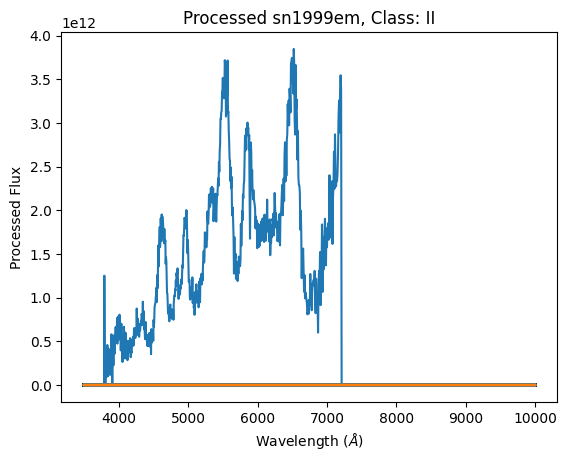

In [ ]:
#@title PROCESSING
from scipy.interpolate import interp1d, UnivariateSpline
import pandas as pd


def zero_non_overlap_part(array, minIndex, maxIndex, outerVal=0.):
    slicedArray = np.copy(array)
    slicedArray[0:minIndex] = outerVal * np.ones(minIndex)
    slicedArray[maxIndex:] = outerVal * np.ones(len(array) - maxIndex)

    return slicedArray


def normalise_spectrum(flux):
    if len(flux) == 0 or min(flux) == max(flux):
        fluxNorm = np.zeros(len(flux))
    else:
        fluxNorm = (flux - min(flux)) / (max(flux) - min(flux))

    return fluxNorm

import re
import numpy as np
def split_flux_uncertainty(flux_str):
    flux_str = flux_str.replace('D', 'E')
    match = re.match(r'(-?\d+\.?\d*(?:E[-+]?\d+)?)-\d+\.?\d*', flux_str)
    if match:
          value = np.float64(match.group(1))
          uncertainty = np.float64(flux_str.split('-', 1)[1])
          return value, uncertainty
    else:
          return np.float64(flux_str), float('nan')

def clean_flux(flux_str):
  try:
    #try to convert directly
    return np.float64(flux_str)
  except ValueError:
    # If direct conversion fails, assume it's in the "value1-value2" format
    parts = flux_str.split('-',maxsplit=1)
    if len(parts) == 2:
      return split_flux_uncertainty(flux_str)

def clean_wavelength(wave_str):
  wave_str = wave_str.replace('D', 'E').replace('d','E')
  match = re.match(r'(-?\d+\.?\d*(?:E[-+]?\d+)?)-\d+\.?\d*', flux_str)
  if match:
          wave_value = np.float64(match.group(1))
          return wave_value
  else:
          return np.float64(wave_str)

preProcess = PreProcessSpectrum(3500, 10000, 1024)

spectra = {'names':[],
           'ages': [],
           'ttypes': [],
           'wavelengths': [],
           'processed_fluxes': []}

for index, filepath in enumerate(filepaths):
  if filepath.endswith(".dat") and not filepath.startswith('./Ia/sn1999'):
      print(filepath)

      ttype = os.path.split(os.path.split(filepath)[0])[-1]
      filename = os.path.basename(filepath)
      sn_name, age_info = os.path.basename(filename).strip('.dat').split('.')

      if age_info == 'max':
          age = 0
      elif age_info[0] == 'm':
          age = -float(age_info[1:])
      elif age_info[0] == 'p':
          age = float(age_info[1:])
      elif age_info[0] == 'u':
          continue
      else:
          print("Skipping Invalid Superfit file: {0}".format(filename))
          continue

      data = pd.read_csv(filepath, names=['wavelength', 'flux'], delim_whitespace=True)
      data.dropna(subset=['flux'], inplace=True)
      wave_str = data['wavelength'].replace('D', 'E').replace('d', 'E')
      flux_str = data['flux'].replace('D', 'E').replace('d', 'E')

      flux = []
      flux_uncertainty = []
      wave = []

      for flux_str in data['flux'].astype(str):
        value, uncertainty = split_flux_uncertainty(flux_str)
        flux.append(value)
        flux_uncertainty.append(uncertainty)

      for wave_str in data['wavelength'].astype(str):
        wave_val = clean_wavelength(wave_str)
        wave.append(wave_val)

      wave = np.array(wave)
      flux = np.array(flux)
      flux_uncertainty = np.array(flux_uncertainty)

      wave, flux, minindex, maxindex  = preProcess.log_wavelength(wave, flux)
      newflux, continuum = preProcess.continuum_removal(wave, flux, 13, minindex, maxindex)
      meanzero = preProcess.mean_zero(newflux, minindex, maxindex)
      apodized = preProcess.apodize(meanzero, minindex, maxindex)
      flux_norm = normalise_spectrum(apodized)
      flux_norm = zero_non_overlap_part(flux_norm, minindex, maxindex, outerVal=0.0)

      spectra['names'].append(sn_name)
      spectra['ages'].append(age)
      spectra['ttypes'].append(ttype)
      spectra['wavelengths'].append(wave)
      spectra['processed_fluxes'].append(flux_norm)

      if not os.path.exists('plots'):
        os.makedirs('plots')

      plt.plot(wave, flux)
      plt.title(f"Name: {filename.split('.')[0]} Class: {ttype}")
      plt.xlabel('Wavelength ($\AA$)')
      plt.ylabel('Flux')
      plt.savefig('plots/raw_spectrum_' + filename.split('.')[0] + '.pdf')

      plt.plot(wave, flux_norm)
      plt.title(f"Processed {filename.split('.')[0]}, Class: {ttype}")
      plt.xlabel('Wavelength ($\AA$)')
      plt.ylabel('Processed Flux')
      plt.savefig('plots/processed_spectrum_' + filename.split('.')[0] + '.pdf')



spectra = pd.DataFrame(spectra)



In [ ]:
spectra.head()

,names,ages,ttypes,wavelengths,processed_fluxes
0,sn1989b,18.0,Ia,"[3500.0, 3503.590099215369, 3507.183880948559,...","[0.30409852013780003, 0.30415408166075386, 0.3..."
1,sn1989b,8.0,Ia,"[3500.0, 3503.590099215369, 3507.183880948559,...","[0.4573226171457718, 0.45720181329341064, 0.45..."
2,sn1989b,17.0,Ia,"[3500.0, 3503.590099215369, 3507.183880948559,...","[0.2899597409474692, 0.2899253882670839, 0.289..."
3,sn1998aq,19.0,Ia,"[3500.0, 3503.590099215369, 3507.183880948559,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,sn1996x,57.0,Ia,"[3500.0, 3503.590099215369, 3507.183880948559,...","[0.0, 0.5820537909579006, 0.5814289191514761, ..."


In [ ]:
def sim_spec(spectrum, num_flux_variations=10):

   sim_spectrum_waves = []
   sim_spectrum_fluxes = []
   sim_spectrum_names = []
   for i in range(num_flux_variations):
    z = np.random.uniform(0, 0.5)
    sim_spectrum_wave = spectrum['wavelengths'] * (1+z)
    sim_spectrum_flux = spectrum['processed_fluxes'] + np.random.normal(0, 0.01, len(spectrum['processed_fluxes']))
    sim_spectrum_fluxes.append(sim_spectrum_flux)
    sim_spectrum_waves.append(sim_spectrum_wave)
    sim_spectrum_names.append(f"{spectrum['names']}_{z}")

   return sim_spectrum_wave, sim_spectrum_flux, z

In [ ]:
def simulate_spectra_df(spectra, num_redshift_variations=10):

    simulated_spectra = []

    for _, spectrum in spectra.iterrows():
        # Duplicate + add noise to fluxes
        for _ in range(num_redshift_variations):
            simulated_spectrum = spectrum.copy()
            simulated_spectrum['processed_fluxes'] += np.random.normal(0, 0.01, len(spectrum['processed_fluxes']))
            simulated_spectra.append(simulated_spectrum)

    simulated_spectra_df = pd.DataFrame(simulated_spectra)

    # Generate redshifts & calculate redshifted wavelengths
    simulated_spectra_df['redshift'] = np.random.uniform(0, 0.5, len(simulated_spectra_df))
    simulated_spectra_df['redshifted_wavelengths'] = simulated_spectra_df['wavelengths'] * (1 + simulated_spectra_df['redshift'])

    return simulated_spectra_df

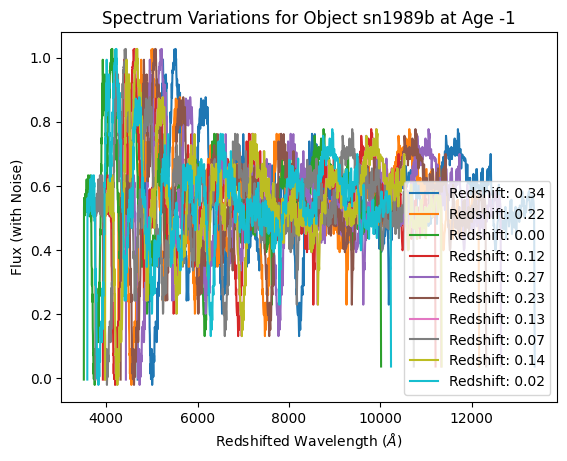

In [ ]:
simulated_spectra_df = simulate_spectra_df(spectra, num_redshift_variations=10)
first_name = simulated_spectra_df['names'].iloc[0]
desired_age = -1
subset = simulated_spectra_df[(simulated_spectra_df['names'] == first_name) & (simulated_spectra_df['ages'] == desired_age)]

plt.figure()

for i, row in subset.iterrows():  # iterate through the 10 copies
    plt.plot(row['redshifted_wavelengths'], row['processed_fluxes'], label=f"Redshift: {row['redshift']:.2f}")

plt.title(f"Spectrum Variations for Object {first_name} at Age {desired_age}")
plt.xlabel('Redshifted Wavelength ($\AA$)')
plt.ylabel('Flux (with Noise)')
plt.legend()
plt.show()

In [ ]:
#train test split + validation
import numpy as np
from sklearn.model_selection import train_test_split

# extract features and target variable
X = simulated_spectra_df[['redshifted_wavelengths', 'processed_fluxes']].values
y = simulated_spectra_df['redshift'].values  # target = redshift(z)

X = np.hstack([
    simulated_spectra_df['redshifted_wavelengths'].apply(np.array).tolist(),
    simulated_spectra_df['processed_fluxes'].apply(np.array).tolist()
])
y = simulated_spectra_df['redshift'].values

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% (test + validation)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% validation, 15% test

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)
print("X shape: ", X.shape)

Training set shape: (2072, 2048) (2072,)
Validation set shape: (444, 2048) (444,)
Testing set shape: (444, 2048) (444,)
X shape:  (2960, 2048)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test, X_val, y_val):

    # Test set evaluation
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Test Mean Squared Error:", mse)
    print("Test R-squared Score:", r2)

    # Validation set evaluation
    y_val_pred = model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)

    print("Validation Mean Squared Error:", mse_val)
    print("Validation R-squared Score:", r2_val)

In [ ]:
def plot_predicted_vs_actual(y_test, y_pred, title="Predicted vs Actual"):

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
             color='red', linestyle='--', label='Ideal')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_residuals_histogram(y_test, y_pred, bins=30, title="Histogram of Residuals"):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=bins)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
evaluate_model(rf_regressor, X_test, y_test, X_val, y_val)

Test Mean Squared Error: 3.361172666964291e-08
Test R-squared Score: 0.9999983231590478
Validation Mean Squared Error: 3.428859503128833e-08
Validation R-squared Score: 0.9999983409207199


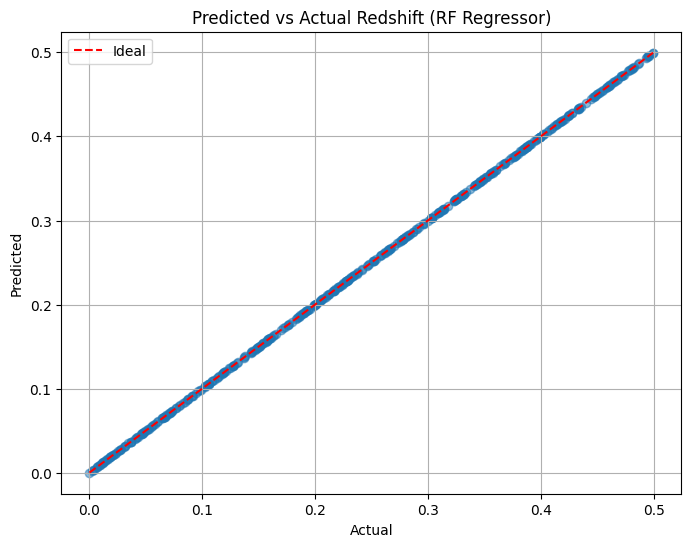

In [ ]:
y_pred_rf = rf_regressor.predict(X_test)
plot_predicted_vs_actual(y_test, y_pred_rf, title="Predicted vs Actual Redshift (RF Regressor)")

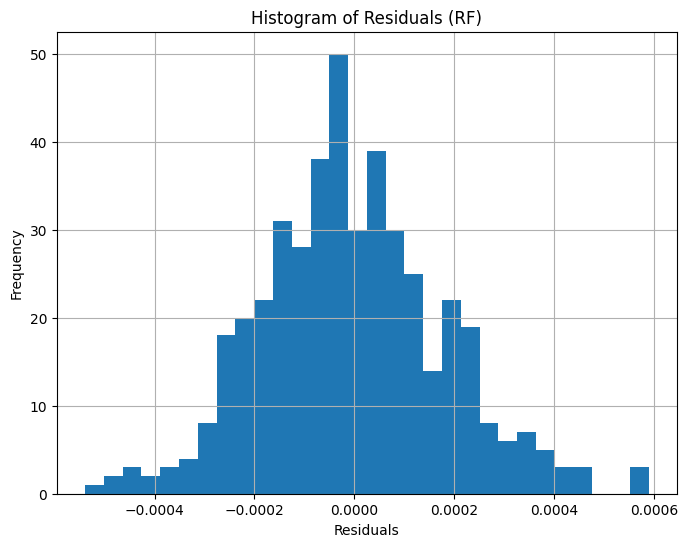

In [ ]:
plot_residuals_histogram(y_test, y_pred_rf, title = "Histogram of Residuals (RF)")

In [ ]:
#GBM using decision trees
!pip install lightgbm==3.3.5
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'regression',  # For redshift prediction
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
}

lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred_lgb = lgb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.184580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509200
[LightGBM] [Info] Number of data points in the train set: 2072, number of used features: 2048
[LightGBM] [Info] Start training from score 0.257378


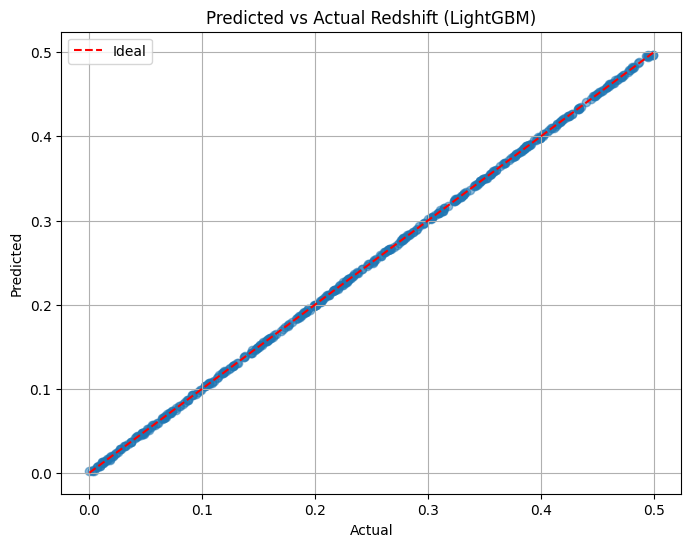

In [ ]:
plot_predicted_vs_actual(y_test, y_pred_lgb, title="Predicted vs Actual Redshift (LightGBM)")

In [ ]:
evaluate_model(lgb_model, X_test, y_test, X_val, y_val)

Test Mean Squared Error: 6.399565604214745e-07
Test R-squared Score: 0.9999680734828437
Validation Mean Squared Error: 7.152071512992574e-07
Validation R-squared Score: 0.9999653941678109


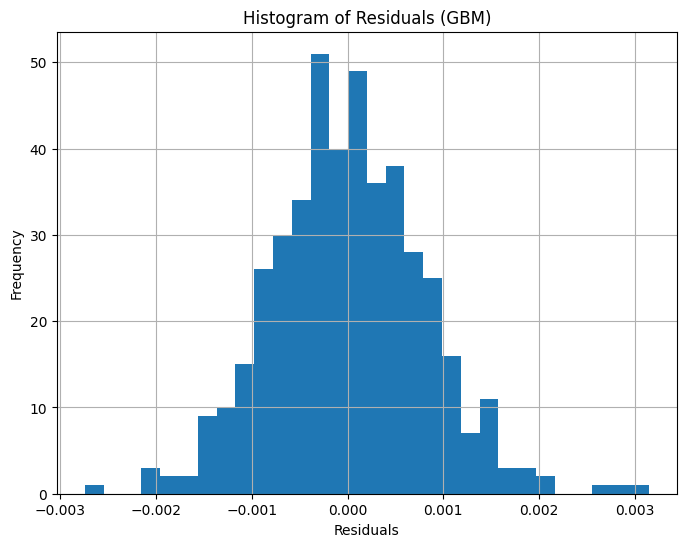

In [ ]:
plot_residuals_histogram(y_test, y_pred_lgb, title = "Histogram of Residuals (GBM)")

In [ ]:
# Paper format

# 1. Introduction
# 2. Data
#   2.1 Processing
# 3. Method
# 4. Results and Discussion
# 5. Conclusions

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

num_samples = X_train.shape[0]
num_features = X_train.shape[1]
X_train_reshaped = X_train.reshape(num_samples, num_features)

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1])

svr_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))

# Train the model using the reshaped X_train
svr_model.fit(X_train_reshaped, y_train)

y_pred_svr = svr_model.predict(X_test_reshaped)

In [ ]:
#evaluating model svr
evaluate_model(svr_model, X_test, y_test, X_val, y_val)

Test Mean Squared Error: 0.001496472631241945
Test R-squared Score: 0.9253431215645178
Validation Mean Squared Error: 0.0015383732034818345
Validation R-squared Score: 0.9255646635704313


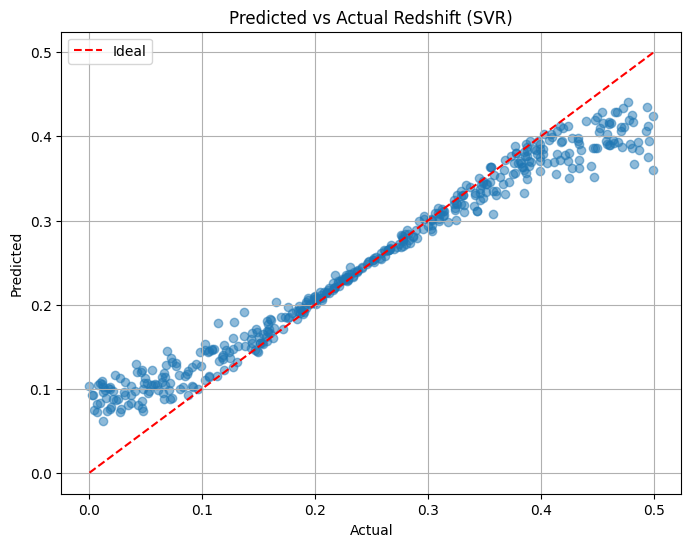

In [ ]:
plot_predicted_vs_actual(y_test, y_pred_svr, title="Predicted vs Actual Redshift (SVR)")

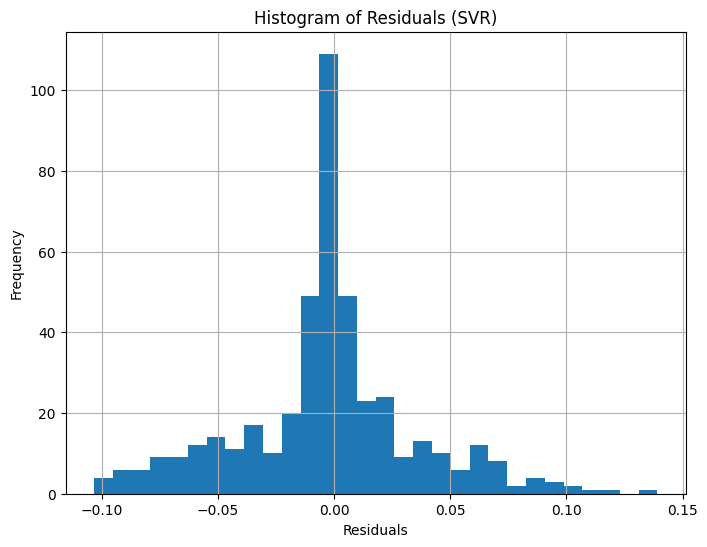

In [ ]:
plot_residuals_histogram(y_test, y_pred_svr, title = "Histogram of Residuals (SVR)")

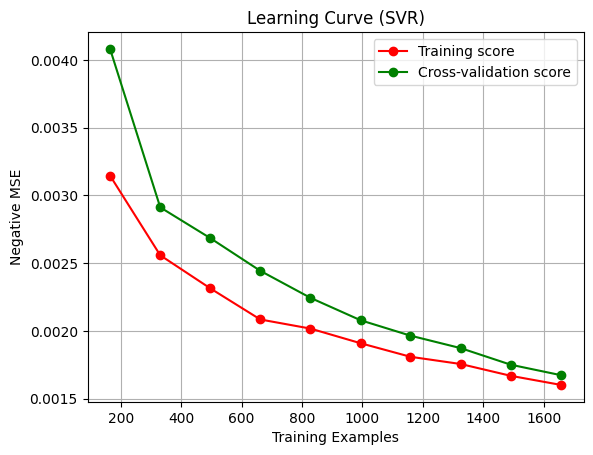

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

train_sizes, train_scores, test_scores = learning_curve(
    make_pipeline(StandardScaler(),SVR(kernel='rbf', C=1.0, epsilon=0.1)), X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (SVR)")
plt.xlabel("Training Examples")
plt.ylabel("Negative MSE")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()